# 1.Import library

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# sys.path.append('/content/drive/My Drive/Luan Van 2019/Tumor/model/src')

In [3]:
def avoid_warning():
    """Disable the warnings and tensorflow's warnings"""
    try:
        import warnings
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', message='foo bar')
        warnings.simplefilter(action='ignore', category=FutureWarning)
        with warnings.catch_warnings():
            # this will suppress all warnings in this block
            warnings.simplefilter("ignore")

        from silence_tensorflow import silence_tensorflow
        silence_tensorflow()
    except Exception as e:
        pass

In [4]:
avoid_warning()

In [5]:
from util.npy_generator import *
from util.metrics import *

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from model import cnn

# 2. Setting model

### 2.1 Create model

In [9]:
input_size = (128, 128, 128)
batch_size = 16
model = cnn.CNN(size=input_size, regularizer_scale=1e-4,base_n_filter = 16, output_activation_name='sigmoid', is_training = True,checkpoint_path = None)

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_9 (Conv3D)               (None, 128, 128, 128 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128, 128, 128 64          conv3d_9[0][0]                   
__________________________________________________________________________________________________
elu_9 (ELU)                     (None, 128, 128, 128 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

### 2.2 Loss function

In [11]:
def Dice_loss(y_true,y_pred):
    return 1.-DICE(y_true,y_pred)
def DICE(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### 2.3 Setting loss, optimizer, metricts

In [14]:
n_epochs = 100
learning_rate = 1e-5
early_stopping_patience = 9
steps_per_epoch = 50*240//batch_size
validation_steps = 6*240//batch_size
# checkpoint_best_valloss_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/best_valid_model14_t2.hdf5"
# checkpoint_best_last_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/last_model14.hdf5"
print('steps_per_epoch: ', steps_per_epoch)
print('validation_steps: ',validation_steps)
# checkpoint_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/best_valid_model14.hdf5"
#model.load_weights(checkpoint_path)
lossWeights = [8.0,1.0,2.0,4.0]

model.compile(optimizer=Adam(lr=learning_rate), loss=Dice_loss, loss_weights = lossWeights,
              metrics=[VOE ,DICE])

steps_per_epoch:  750
validation_steps:  90


### 2.4 Getting data

In [0]:
import glob
X_train = glob.glob(r'/content/drive/My Drive/Dataset2/data/data_4/train/scan*')
y_train = glob.glob(r'/content/drive/My Drive/Dataset2/data/data_4/train/gt*')
X_val = glob.glob(r'/content/drive/My Drive/Dataset2/data/data_4/valid/scan*')
y_val = glob.glob(r'/content/drive/My Drive/Dataset2/data/data_4/valid/gt*')
X_train.sort()
y_train.sort()
X_val.sort()
y_val.sort()

print("Length of data train: ",len(X_train))
print("Length of data test: ",len(X_val))

print(X_train)
print(y_train)
print(X_val)
print(y_val)

Length of data train:  50
Length of data test:  8
['/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part001.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part002.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part003.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part004.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part005.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part006.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part007.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part008.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part009.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part010.npy', '/content/drive/My Drive/Dataset2/data/data_4/train/scan-n0240-s64_64_64.part01

Show several slice in sample

In [0]:
print(X_train[5],"|",y_train[5])
a=np.load(X_train[5])
b=np.load(y_train[5])
from matplotlib import pyplot as plt
temp=0
for i in range(32):
  if b[154][:,:,i].max()==1:
    temp=i
    break
d=(a[154][:,:,10])
e=np.pad(d, [(150, 150), (150, 150)], mode='constant')
plt.imshow(e,cmap="gray")
plt.show()

plt.imshow(b[154][:,:,10],cmap="gray")
plt.show()
plt.imshow(a[154][:,:,10],cmap="gray")
plt.show()

###2.5 Set data, callbacks

In [0]:
training_generator = npy_generator(X_train,y_train, use_normalize = False, batch_size=batch_size, n_outputs = 4, subtract_mean = None,reshape = True)
validation_generator = npy_generator(X_val,y_val, use_normalize = False, batch_size=batch_size, n_outputs = 4, subtract_mean = None,reshape = True)
model_checkpoint_valloss = ModelCheckpoint(checkpoint_best_valloss_path, monitor='val_score_main_loss', verbose = 1, save_best_only=True)
model_checkpoint_last = ModelCheckpoint(checkpoint_best_last_path, verbose = 1, save_best_only=False)
learning_rate_plateau_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=n_epochs//2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-9)
early_stopping = EarlyStopping(verbose = 1, patience=early_stopping_patience)
logfile = "/content/drive/My Drive/Luan Van 2019/Tumor/log/log_model14.csv"
csv_logger = CSVLogger(logfile, separator=',', append=True)
call_backs = [ model_checkpoint_valloss,model_checkpoint_last ,learning_rate_plateau_loss,csv_logger, early_stopping]

# 3. Training



1.   Model10: data test 4 (50 train,8 valid)
2. Loss: Dice_loss



In [0]:
model.fit_generator(generator=training_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=n_epochs,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=call_backs)

Epoch 1/100
 90/750 [==>...........................] - ETA: 5:57 - loss: 5.9834 - score_main_loss: 0.3635 - score_aux1_loss: 0.6710 - score_aux2_loss: 0.4334 - score_aux3_loss: 0.3563 - score_main_VOE: 0.5057 - score_main_DICE: 0.6365 - score_aux1_VOE: 0.7888 - score_aux1_DICE: 0.3290 - score_aux2_VOE: 0.5859 - score_aux2_DICE: 0.5666 - score_aux3_VOE: 0.4958 - score_aux3_DICE: 0.6437
Epoch 00001: val_score_main_loss improved from inf to 0.36349, saving model to /content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/best_valid_model14_t2.hdf5

Epoch 00001: saving model to /content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/last_model14.hdf5
750/750 [==============================] - 619s 825ms/step - loss: 4.2852 - score_main_loss: 0.2156 - score_aux1_loss: 0.6381 - score_aux2_loss: 0.4002 - score_aux3_loss: 0.2523 - score_main_VOE: 0.3438 - score_main_DICE: 0.7844 - score_aux1_VOE: 0.7599 - score_aux1_DICE: 0.3619 - score_aux2_VOE: 0.5587 - score_aux2_DICE

# 4. Drawing chart

In [8]:
listLoss=[]
listScoreVOE=[]
list_val_croreVOE=[]
list_val_loss=[]
listDice=[]
list_valid_Dice=[]
import csv

# load log1
with open('/content/drive/My Drive/Luan Van 2019/Tumor/log/log_model14.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        listLoss.append(row[1])
        listScoreVOE.append(row[13])
        list_val_croreVOE.append(row[26])
        list_val_loss.append(row[15])
        listDice.append(row[12])
        list_valid_Dice.append(row[25])
csvFile.close()
        
csvFile.close()
print(listLoss)
print(len(listScoreVOE))
print(len(list_val_croreVOE))

epoch=[x for x in range(len(listLoss)-1)]

['loss', '8.225559495608012', '7.642939207712809', '6.96855551815033', '6.777826100190481', '6.243636131604513', '5.989897627035777', '5.564770492871602', '5.497973432223002', '5.380069477717082', '5.101675776004791', '5.183015250682831', '5.127977187474569', '4.897152982870738', '4.919878529389699', '4.676334974288941', '4.651393795967102', '4.486052726268769', '4.346892293771108', '4.220647819677989', '4.194299599488576', '4.216445701917013', '4.130873724937439', '4.08550047492981', '4.049492556889852', '4.163534436225891', '4.285212034702301', '4.252987904548645', '4.153205324172974', '4.124651806195577', '4.102453048706055', '4.07687018473943', '4.057927319526672', '4.029683551629384', '3.986362511952718', '3.998282553990682', '3.9855753208796183', '3.976503726005554', '3.9167486271858216', '3.9091379636128742']
40
40


In [0]:
listLoss=[ float(x)/15.0 for x in listLoss[1:]]
list_val_loss=[float(x)/15.0 for x in list_val_loss[1:]]
listScoreVOE=[float(x) for x in listScoreVOE[1:]]
list_val_croreVOE=[float(x) for x in list_val_croreVOE[1:]]
listDice=[float(x) for x in listDice[1:]]
list_valid_Dice=[float(x) for x in list_valid_Dice[1:]]

In [0]:
from matplotlib import pyplot as plt

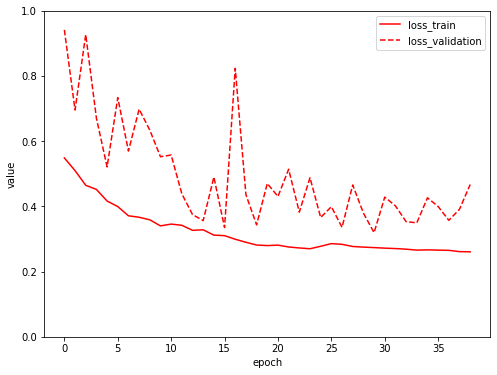

In [26]:
plt.figure(figsize=(8,6))
plt.plot(epoch,listLoss,'r',label="Loss")
plt.plot(epoch,list_val_loss,'r--',label="Loss")
#plt.plot(epoch,listDice,'b',label="Score")
#plt.plot(epoch,list_valid_Dice,'b--',label="Score")
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['loss_train','loss_validation'], loc='upper right')
plt.ylim(0,1)
plt.savefig("/content/drive/My Drive/Luan Van 2019/Tumor/Report/Model_CNN14_loss.png")
plt.show()
plt.close()

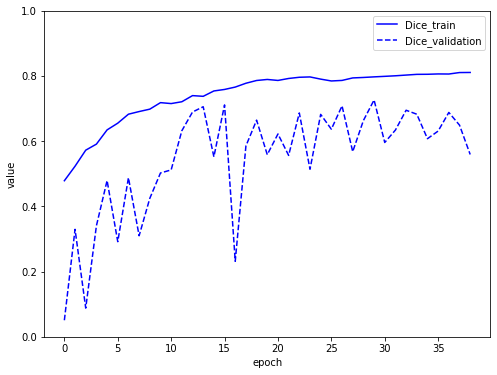

In [25]:
plt.figure(figsize=(8,6))
#plt.plot(epoch,listLoss,'r',label="Loss")
#plt.plot(epoch,list_val_loss,'r--',label="Loss")
plt.plot(epoch,listDice,'b',label="Score")
plt.plot(epoch,list_valid_Dice,'b--',label="Score")
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['Dice_train','Dice_validation'], loc='upper right')
plt.ylim(0,1)
plt.savefig("/content/drive/My Drive/Luan Van 2019/Tumor/Report/Model_CNN14_Dice.png")
plt.show()
plt.close()